# Computation in superposition
The goal of this notebook is to explore, how computation in superposition works. This is inspired by the paper [Mathematical Models of Computation in Superposition](https://arxiv.org/abs/2408.05451).

According to the paper, a one layer MLP with ReLU activations is able to compute the Universal AND (UAND) of binary features in superposition. We do experiments to see if the model actually learns this:

1. Naive Computation of UAND
2. Computation of UAND in superposition for basis-aligned features
3. Computation of UAND in superposition for not basis-aligned features

## Notation
We consider a fully-connected Neural Network $M:X \rightarrow Y$ with $L$ layers and ReLU activation functions. Let $x$ be the input of the MLP and let $d$ be the dimension of the hidden layers. We denote by $m$ the number of features.

For $k \in \{1,...,m \}$ we call a function $f_k:X \rightarrow \{0,1\}$ a boolean feature. A common assumption is that features are represented as directions in the activation space, i.e. that the activation of a given layer is given by $a(x) = \sum_i v_i f_i(x)$, where $v_1,...,v_m \in \mathbb R^d$ are called feature vectors. We call these basis aligned, if they correspond to the coordinate directions. A NN can (noisily) represent more feaures than it has dimensions ($m>d$) by choosing almost orthohonal feature vectors [Toy Models of Superposition](https://arxiv.org/abs/2209.10652).

Let $b \in \{ 0,1\}^m$ be a boolean vector. The UAND of b has $m \choose 2$ outputs, where each output is the AND of one of the ordered pairs.



## 1. Naive computation of UAND
For two boolean variables $x_1,x_2$, we can calculate their AND via $x_1 \wedge x_2 = ReLU(x_1+ x_2 -1)$. We can create a one-layer NN, with $m$ dimensional input and $m \choose 2$ neurons, that are taking the AND of two inputs. This Implements the UAND, where the activation of the output gives us a basis aligned and of the input features.

In [148]:
import torch
import einops
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import tqdm.auto as tqdm

In [149]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.W_in = nn.Parameter(torch.randn(d_hidden, d_in) / np.sqrt(d_in))
        self.b_in = nn.Parameter(torch.zeros(d_hidden) - 1)

    def forward(self, x):           # x shape: (d_in, batch)
        x = torch.einsum('dm, mb -> db', self.W_in, x)  # (d_hidden, batch)
        x = x + self.b_in[:, None]                      # broadcast bias
        return F.relu(x)

In [161]:
# Setup
m = 20
d = int(m*(m-1)/2)
batch_size = 100000
train_frac = 0.3
device = "cpu"

In [163]:
bool_vecs = torch.randint(low = 0,high = 2, size = (m,batch_size))


output_size  = int(m*(m-1)/2)
out_vec = torch.zeros(size = (output_size,batch_size))
#This for loop is inredibly inefficient and can probably be vecorized
"""
for batch in range(batch_size):
    k = 0
    for i in range(m):
        for j in range(i+1,m):
            if bool_vecs[i,batch] == 1 and bool_vecs[j,batch] == 1:
                out_vec[k,batch] = 1
            k +=1
"""
idx_i, idx_j = torch.triu_indices(m, m, offset=1)  # all pairs i<j
out_vec = (bool_vecs[idx_i] & bool_vecs[idx_j]).float()  # (d, batch)


#Split into train and test data
split = int(train_frac*batch_size)
train_data = bool_vecs[:,:split].to(torch.float32)
train_labels = out_vec[:,:split].to(torch.float32)
test_data = bool_vecs[:,split:].to(torch.float32)
test_labels = out_vec[:,split:].to(torch.float32)

print(train_data.shape)
print(train_labels.shape)
print(m*(m-1)/2)


torch.Size([20, 30000])
torch.Size([190, 30000])
190.0


In [164]:
one_layer_mlp = MLP(m,d).to(device=device)
one_layer_mlp(train_data)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9027,  ..., 0.0000, 0.1156, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

In [165]:
#training parameters
n_epoch = 10000
lr = 1e-3
wd = 1.
DATA_SEED = 346
betas = (0.9,0.98)


In [166]:
# Define optimizer
optimizer = torch.optim.AdamW(one_layer_mlp.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [167]:
#Define loss
def loss_fn(pred, target):
    """
    pred   : Tensor of arbitrary shape
    target : same shape as pred
    returns: scalar mean((pred - target)^2)
    """
    return (pred - target).pow(2).mean()


pred = one_layer_mlp(train_data)
loss2 = loss_fn(pred, train_labels)
print(loss(one_layer_mlp(train_data),train_labels))


tensor(0.2539, grad_fn=<MseLossBackward0>)


In [ ]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_pred = one_layer_mlp(train_data)
    train_loss = loss_fn(train_pred,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    with torch.inference_mode():
        test_pred = one_layer_mlp(test_data)
        test_loss = loss_fn(test_pred,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 103/10000 [00:03<04:52, 33.87it/s]

Epoch 99 Train Loss 0.22292789816856384 Test loss 0.22165447473526


  2%|▏         | 203/10000 [00:06<05:01, 32.46it/s]

Epoch 199 Train Loss 0.18211495876312256 Test loss 0.18105600774288177


  3%|▎         | 304/10000 [00:09<04:47, 33.78it/s]

Epoch 299 Train Loss 0.15319542586803436 Test loss 0.1524365097284317


  4%|▍         | 404/10000 [00:12<04:42, 34.00it/s]

Epoch 399 Train Loss 0.1384338140487671 Test loss 0.13779056072235107


  4%|▍         | 420/10000 [00:12<05:07, 31.15it/s]

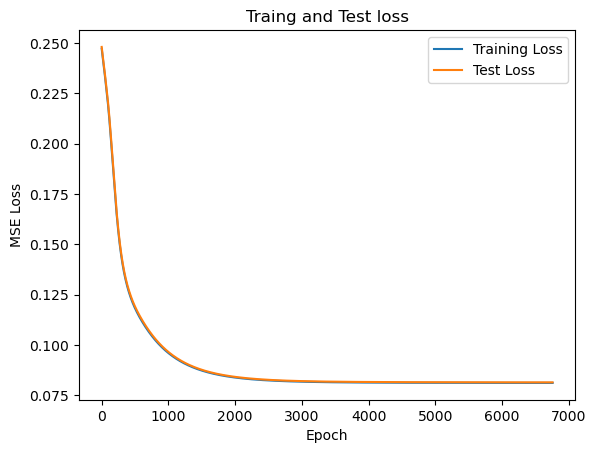

In [160]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
#plt.yscale("log")
plt.title("Traing and Test loss")
plt.legend()
plt.show()